In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from sklearn.model_selection import train_test_split

In [2]:
def export_csv():
    # Left lower extremity
    res = {}

    # # Annotations and Metadata
    # res['GRF_Annotation'] = pd.read_csv(r'https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/22062960/GRF_metadata.csv')

    # Left lower extremity
    #res['GRF_F_V_PRO_left'] = pd.read_csv(r'GRF_F_V_PRO_left.csv')

    #res['GRF_F_AP_PRO_left'] = pd.read_csv(r'GRF_F_AP_PRO_left.csv')

    #res['GRF_F_ML_PRO_left'] = pd.read_csv(r'GRF_F_ML_PRO_left.csv')

    # res['GRF_COP_AP_PRO_left'] = pd.read_csv(r'GRF_COP_AP_PRO_left.csv')

    # res['GRF_COP_ML_PRO_left'] = pd.read_csv(r'GRF_COP_ML_PRO_left.csv')

    # Right lower extremity
    #res['GRF_F_V_PRO_right'] = pd.read_csv(r'GRF_F_V_PRO_right.csv')

    #res['GRF_F_AP_PRO_right'] = pd.read_csv(r'GRF_F_AP_PRO_right.csv')

    res['GRF_F_ML_PRO_right'] = pd.read_csv(r'GRF_F_ML_PRO_right.csv')

    #res['GRF_COP_AP_PRO_right'] = pd.read_csv(r'GRF_COP_AP_PRO_right.csv')

    #res['GRF_COP_ML_PRO_right'] = pd.read_csv(r'GRF_COP_ML_PRO_right.csv')

    # Annotations and Metadata
    res['GRF_Annotation'] = pd.read_csv(r'GRF_metadata.csv')
    return res

In [3]:
df_dict = export_csv()

In [4]:
def getTitle(label):
    if label=="HC":
        return "Healthy Controls"
    elif label=="K":
        return "Knee impairment "
    elif label=="A":
        return "Ankle impairment"
    elif label=="H":
        return "Hip impairment"
    else:
        return "Calcaneus impairment"

In [5]:
def get_Inputs(grf, meta, label):
    subject_id = meta.loc[meta["CLASS_LABEL"]==label]["SUBJECT_ID"].unique()
    subject_id = pd.DataFrame({"SUBJECT_ID": subject_id})
    grf = subject_id.merge(grf, on="SUBJECT_ID", how = "inner")
    #grf = grf.drop_duplicates(['SUBJECT_ID'], keep = 'first')
    #grf.drop(grf.columns[:3], axis = 1)
    grf = grf.iloc[:,3:].values
    res = np.array(grf)
    return res

In [6]:
X = None
for key in df_dict:
    if key== 'GRF_Annotation': 
        continue
    temp = get_Inputs(df_dict[key], df_dict['GRF_Annotation'], 'HC') #data of healthy controls is used for training
    if X is None:
        X = temp
    else:
        X = np.append(X, temp, axis=0)
print(X.shape)

(7755, 101)


In [7]:
#scaling and reshaping of the input data for the model
scaler = MinMaxScaler(feature_range=(0, 1))
#print('X', X)
X = scaler.fit_transform(X)
#print('X_new', X)
l1, l2 = 0.6, 0.9
X_train = X[0:(int)(X.shape[0]*l1), :]
X_val = X[(int)(X.shape[0]*l1):(int)(X.shape[0]*l2), :]
X_test = X[(int)(X.shape[0]*l2):, :]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4653, 101)
(2326, 101)
(776, 101)


In [8]:
#X = get_Inputs(df_dict['GRF_F_V_PRO_left'], df_dict['GRF_Annotation'], 'A')

In [9]:
def get_data_series(X, serie_size):
    #first_step = 0 #X.shape[1] - serie_size - 1
    print(X.shape)
    last_step = X.shape[1]
    data_series = []
    for row in X:
        for step1 in range(last_step - serie_size):
            serie = row[step1 : step1 + serie_size]
            # for step2 in range(serie_size):
            #     serie.append(row[step1 + step2])
            data_series.append(serie)
    res = np.array(np.squeeze(np.array(data_series)))
    print(res.shape)
    return res

In [10]:
X_train, X_val, X_test = get_data_series(X_train, 16),get_data_series(X_val, 16) ,get_data_series(X_test, 16)

X_train, X_val, X_test = X_train.reshape(X_train.shape[0], X_train.shape[1], 1),X_val.reshape(X_val.shape[0], X_val.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print('X_train.shape ',X_train.shape)
print('X_val.shape ',X_val.shape)
print('X_test.shape ',X_test.shape)

(4653, 101)
(395505, 16)
(2326, 101)
(197710, 16)
(776, 101)
(65960, 16)
X_train.shape  (395505, 16, 1)
X_val.shape  (197710, 16, 1)
X_test.shape  (65960, 16, 1)


In [11]:
serie_size  =  X_train.shape[1] # equal to the lookback
n_features =  X_train.shape[2] # 1

epochs = 150
batch = 128
lr = 0.001

In [12]:
#using LSTM-AE
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=True))
#lstm_autoencoder.add(LSTM(8, activation='relu'))
lstm_autoencoder.add(LSTM(4, activation='relu'))
lstm_autoencoder.add(RepeatVector(serie_size))
# lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
# lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
# lstm_autoencoder.add(RepeatVector(serie_size))
# # Decoder
# lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
# lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=True))
#lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 8)             800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 16, 4)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 8)             416       
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 16)            1600      
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 1)             1

In [13]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(X_val, X_val),
                                                verbose=2).history

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set th

Epoch 90/150
3090/3090 - 560s - loss: 1.1567e-04 - val_loss: 1.1682e-04
Epoch 91/150
3090/3090 - 560s - loss: 1.1542e-04 - val_loss: 1.1738e-04
Epoch 92/150
3090/3090 - 567s - loss: 1.1546e-04 - val_loss: 1.1118e-04
Epoch 93/150
3090/3090 - 573s - loss: 1.1533e-04 - val_loss: 1.1933e-04
Epoch 94/150
3090/3090 - 564s - loss: 1.1522e-04 - val_loss: 1.1774e-04
Epoch 95/150
3090/3090 - 580s - loss: 1.1508e-04 - val_loss: 1.1105e-04
Epoch 96/150
3090/3090 - 633s - loss: 1.1482e-04 - val_loss: 1.1553e-04
Epoch 97/150
3090/3090 - 658s - loss: 1.1477e-04 - val_loss: 1.1071e-04
Epoch 98/150
3090/3090 - 660s - loss: 1.1466e-04 - val_loss: 1.1228e-04
Epoch 99/150
3090/3090 - 603s - loss: 1.1449e-04 - val_loss: 1.1199e-04
Epoch 100/150
3090/3090 - 621s - loss: 1.1446e-04 - val_loss: 1.0963e-04
Epoch 101/150
3090/3090 - 681s - loss: 1.1427e-04 - val_loss: 1.1266e-04
Epoch 102/150
3090/3090 - 619s - loss: 1.1404e-04 - val_loss: 1.1209e-04
Epoch 103/150
3090/3090 - 648s - loss: 1.1409e-04 - val_loss:

In [14]:
import matplotlib

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
#matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
matplotlib.rc('axes', labelsize=BIGGER_SIZE)
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) 

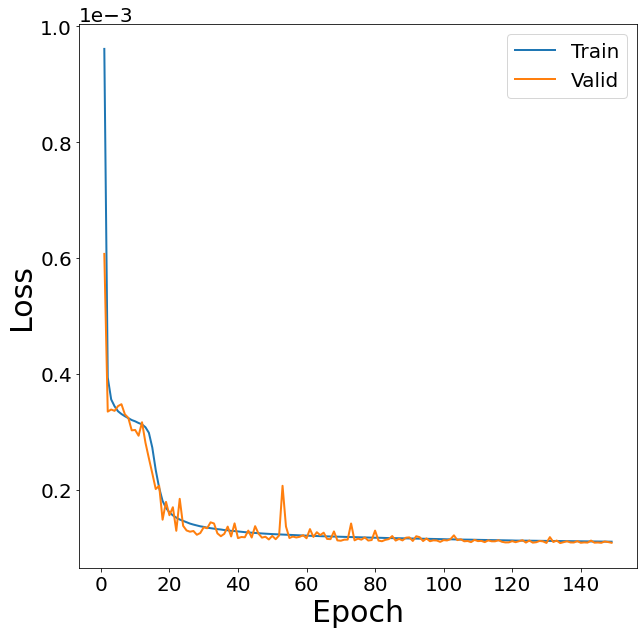

In [16]:
start = 1
plt.figure(figsize= (10,10))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
loss_train = lstm_autoencoder_history['loss'][start:]
plt.plot(np.arange(start, len(lstm_autoencoder_history['loss'])), loss_train, linewidth=2, label='Train')
loss_valid = lstm_autoencoder_history['val_loss'][start:]
plt.plot(np.arange(start, len(lstm_autoencoder_history['loss'])), loss_valid, linewidth=2, label='Valid')
plt.legend(loc='upper right')
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.savefig("loss_plot_right_ml_ae.png")
plt.show()